# Pipelines tutorial

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data

data = pd.read_csv("./melbourne-houses/inputs/melb_data.csv")

# Separete target from predictors
y = data.Price
X = data.drop("Price", axis=1)

# Divide data into train and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                                test_size=0.2, 
                                                                random_state=0)

# Select only categorical features with low cardinality (< 10 unique values)

categorical_cols = [col for col in X_train_full.columns 
                    if X_train_full[col].nunique() < 10 
                    and X_train_full[col].dtype == "object"]

# Select only numerical features
numeric_cols = [col for col in X_train_full.columns 
                    if X_train_full[col].dtype in ["bool","int64","int32","float32","float64"]]

cols = numeric_cols + categorical_cols
X_train = X_train_full.copy()[cols]
X_valid = X_valid_full.copy()[cols]

In [8]:
X_train.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type,Method,Regionname
12167,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0,u,S,Southern Metropolitan
6524,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0,h,SA,Western Metropolitan
8413,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0,h,S,Western Metropolitan
2919,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0,u,SP,Northern Metropolitan
6043,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0,h,S,Western Metropolitan


# Define preprocessing steps

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [11]:
# Numerical columns: impute nulls
numeric_preprocessing_pipe = Pipeline([("impute_nulls",SimpleImputer(strategy='median'))])

# Categorical columns: impute nulls, OH encode 
categorical_preprocessing_pipe = Pipeline(steps =[
    ("impute_nulls", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))
])

# Handle categorical and numerical columns
preprocessing_pipe = ColumnTransformer(
    transformers=[("categorical",categorical_preprocessing_pipe, categorical_cols),
                  ("numeric",numeric_preprocessing_pipe, numeric_cols)],
    n_jobs=3
)

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

In [13]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessing_pipe),
    ("model", model)
])

In [14]:
# Preprocessing of trainin data, fit model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=3,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('impute_nulls',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Method',
                                                   'Regionname']),
                                                 ('numeric',
                                                  Pipeline(steps=[('impute_nulls',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Rooms', 'Distance',
                                                   'Postcode', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [15]:
# Preprocessing of validatrion data, get predicions
preds = pipe.predict(X_valid)

In [17]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(y_valid, preds)
print("MAE", score)

MAE 161788.8606890385


# XGBoost

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data

data = pd.read_csv('./melbourne-houses/inputs/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms','Distance','Landsize', 'BuildingArea','YearBuilt']
X = data[cols_to_use]
y = data["Price"]

# Separate data into trianing and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

In [19]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
from sklearn.metrics import mean_absolute_error

preds = my_model.predict(X_valid)
print("MAE: ", mean_absolute_error(preds, y_valid))

MAE:  244949.65519375922


## Parameters
- `n_estimators` (form 10 to 1000)
- `early_stopping_rounds` (allows to find optimal n_estimators when loss stops decreasing for i rounds)

When using `early_stopping_rounds`, you should pass a `eval_set = [(X_valid, y_valid)]` parameter to the model

In [45]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
preds = my_model.predict(X_valid)
print("MAE: ", mean_absolute_error(preds, y_valid))

MAE:  254671.30061355163


In [47]:
my_model = XGBRegressor(n_estimators=500, 
                        early_stopping_rounds=5)
my_model.fit(X_train,y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
preds = my_model.predict(X_valid)
print("MAE: ", mean_absolute_error(preds, y_valid))

MAE:  249388.15001380706


In [49]:
my_model.best_ntree_limit

36

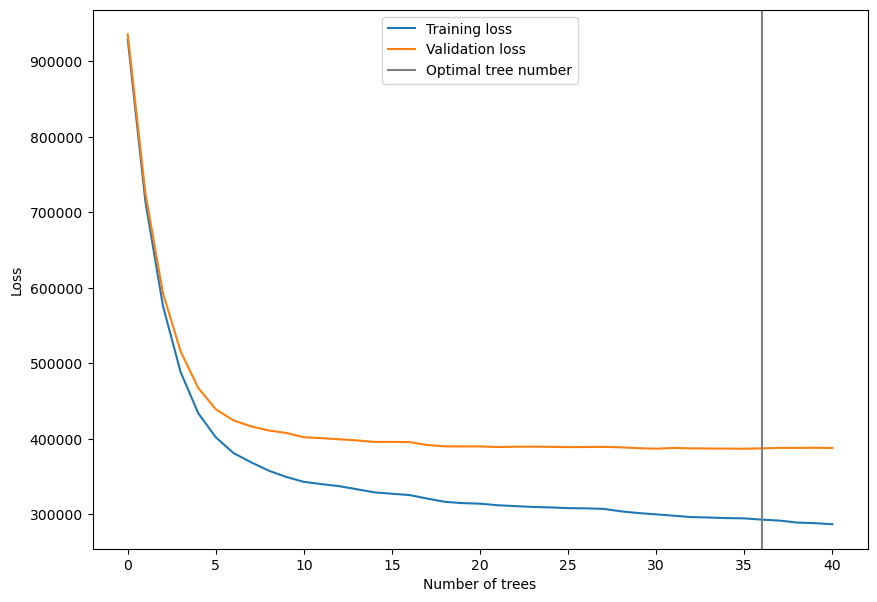

In [50]:
import matplotlib.pyplot as plt
results = my_model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(my_model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [43]:
results

{'validation_0': OrderedDict([('rmse',
               [935753.0281010591,
                725582.4206836581,
                592729.9323338678,
                515989.0558777901,
                467488.97692845354,
                439223.75957791816,
                424415.34570605366,
                416626.7255354751,
                411129.58646547946,
                407875.1978831713,
                402126.86999349494,
                400990.30676214985,
                399459.2676449666,
                397994.1802103123,
                395979.96698404645,
                396007.2368707356,
                395713.6883486489,
                391867.4122373327,
                390118.8704521257,
                389985.76483490056,
                390037.3530821438,
                389241.451694303,
                389628.74634740525,
                389713.6105963174,
                389519.6052108589,
                389104.3088196894,
                389203.75802356395,
       

- `learning_rate` multiplier of predictions (each tree we add helps less)
- if 0 < `learning_rate` < 1, model takes longer to learn. but can be more precise

In [52]:
my_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05,
    early_stopping_rounds=5, 
    n_jobs=3)

my_model.fit(X_train, y_train, 
             eval_set=[(X_train, y_train),(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=3, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [53]:
preds = my_model.predict(X_valid)
print("MAE: ", mean_absolute_error(preds, y_valid))

MAE:  256087.92854381443


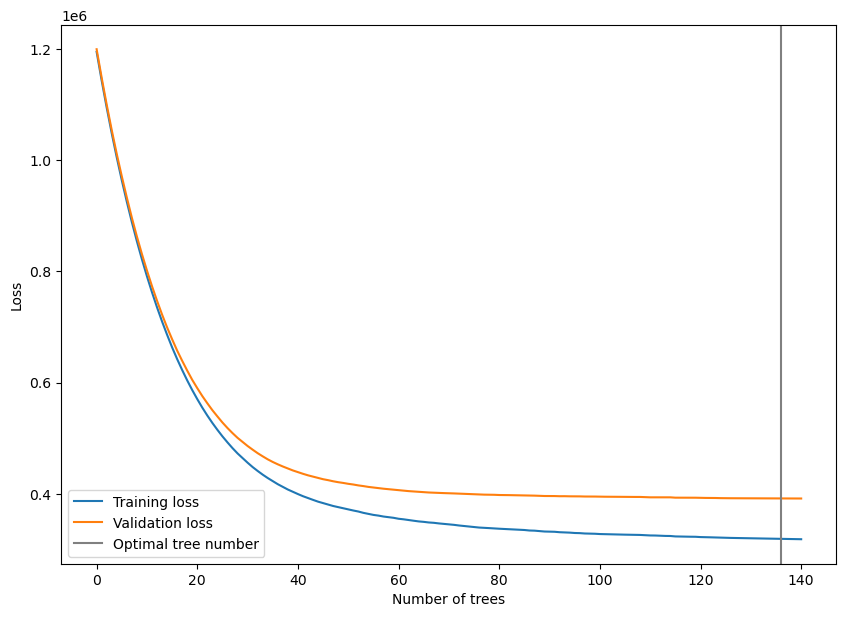

In [54]:
import matplotlib.pyplot as plt
results = my_model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(my_model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()